In [1]:
import numpy as np
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
from metpy.units import units
from metpy.constants import *
import metpy.calc as mpcalc 
from NotebookFinder import *
sys.meta_path.append(NotebookFinder())
import importlib
import Droplet_Adiabatic_Condensation_Growth as DACG
import ARMBE
import Twomey_Droplet_Activation as Twomey
import ACEENA_Read_RF_data
import ACEENA_hleg_microphysics
import ACEENA_vleg_microphysics

importing Jupyter notebook from Droplet_Adiabatic_Condensation_Growth.ipynb
importing Jupyter notebook from ARMBE.ipynb
importing Jupyter notebook from Twomey_Droplet_Activation.ipynb
importing Jupyter notebook from ACEENA_Read_RF_data.ipynb
importing Jupyter notebook from ACEENA_AIMMS.ipynb
importing Jupyter notebook from ACEENA_ARSCL.ipynb
importing Jupyter notebook from ACEENA_CEIL.ipynb
importing Jupyter notebook from ACEENA_FCDP.ipynb
importing Jupyter notebook from ACEENA_TDS.ipynb
importing Jupyter notebook from ACEENA_HOLODEC.ipynb
importing Jupyter notebook from ACEENA_VISST.ipynb
importing Jupyter notebook from ACEENA_Utility.ipynb
importing Jupyter notebook from ACEENA_TDL.ipynb
importing Jupyter notebook from ACEENA_LWCair.ipynb
importing Jupyter notebook from ACEENA_mergedPSD.ipynb
importing Jupyter notebook from ACEENA_AAFCCN.ipynb
importing Jupyter notebook from ACEENA_hleg_microphysics.ipynb
importing Jupyter notebook from ACEENA_vleg_microphysics.ipynb


In [ ]:
def plot_growth_parameter():
    '''
    plot the Figure 7.1 in the R&Y book 
    '''
    T=np.arange(-30,32,2)*units('degreeC')
    P=np.arange(100,35,-5)*units('kPa')
    esp = np.full((P.size,T.size),np.nan) *units('m^2 /s')
    for i in range(P.size):
        for j in range(T.size):
            x=1.0/(DACG.Fk(T[j])+DACG.Fd(T[j],P[i]))
            #print(T[i],P[j],Fk(T[i]),Fd(T[i],P[j]),x[0])
            esp[i,j]=x[0]

    fig,ax=plt.subplots()
    ct=ax.pcolormesh(T,P,np.log10(esp.magnitude*1e12))
    plt.colorbar(ct,label=r'Growth Parameter $\frac{1}{F_k+F_d} [\mu m^2/s]$')
    ax.set_ylim([100,40])
    ax.set_xlabel('Temperature [C]',fontsize='x-large')
    ax.set_ylabel('Pressure [kPa]',fontsize='x-large')
    plt.show()
    # logeps=np.log10(esp.magnitude*1e12)
    # print(logeps.max())
    
plot_growth_parameter()

### examples of single droplet growth by diffsion in Table 7.2 from Mason 1971
The results are similar but a bit faster that thoses in Table 7.2. It seems that the a/r and b/r^3 terms are not considered in Mason 1971. 

In [ ]:
def single_droplet_growth_example(SS,T,P,\
                                  initial_r,final_r,\
                                  dt=1e-1*units('s'),\
                                  solute_mass=1e-13*units('g')):
    '''
    this program computes the time needed to grow a single droplet
    from the initial radius 
    '''
    d  = DACG.Droplet()
    d.set_conditions(initial_r,T,P,solute_mass=solute_mass)
    S  = 1.0+SS
    t0 = 0
    while d.r<final_r:
        d.diffusion_growth_tendency(S)
        dr = d.drdt*dt
        d.set_conditions(d.r+dr,T,P)
        t0+=dt
    return t0

T  = 283*units('K')
P  = 80*units('kPa')
SS = 0.0005
r0  = 1.0*1e-6*units('m')
r1  = 5.0*1e-6*units('m')
time_to_grow = single_droplet_growth_example(SS,T,P,r0,r1,dt=1e-2*units('s'),solute_mass=1e-14*units('g'))
print(time_to_grow)
    

### plot the figure 7.2 the Q1 and Q2 terms

In [ ]:
def plot_Q1_Q2():
    a1,a2 = [],[]
    T = np.arange(-30,20,1) * units('degreeC')
    P1 = 800 * units('hPa')
    P2 = 600 * units('hPa')
    W = 15 * units('cm/s')
    mr = 4.25 *units('g/kg')
    for Temp in T:
        ap1 = DACG.air_parcel()
        ap2 = DACG.air_parcel()
        ap1.init_conditions(Temp,P1,W,mr)
        ap2.init_conditions(Temp,P2,W,mr)
        a1.append(ap1)
        a2.append(ap2)

    Q1_all = [a1[i].Q1.magnitude for i in range(T.size)]
    Q2_all = [a1[i].Q2.magnitude for i in range(T.size)]

    Q1_all_P2 = [a2[i].Q1.magnitude for i in range(T.size)]
    Q2_all_P2 = [a2[i].Q2.magnitude for i in range(T.size)]

    fig,ax=plt.subplots()
    ax.plot(T,np.array(Q1_all)*1e4,ls='dashed')
    ax.set_ylim([4,8])
    axr=ax.twinx()
    axr.plot(T,np.array(Q2_all)*1e-3,c='b')
    axr.plot(T,np.array(Q2_all_P2)*1e-3,c='r')
    axr.set_ylim([0.2,2.7])
    
    #print(a.Q1,a.Q2,a.Es,a.E,a.E/a.Es)
plot_Q1_Q2()

In [2]:
def condesation_growth_in_adiabatic_air_parcel(T0,P0,H0,W,CCN,P1):
    '''
    Inputs:
    T0: initial temperatire of the air parcel
    P0: initial pressure of the air parcel
    W:  vertical velocity of the air parcel
    CCN: CCN concentration in the air parcel
    '''
    smax = Twomey.Twomey_smax(W,CCN)
    CDNC = Twomey.Twomey_Droplet_Activation_s(smax,CCN)
    mr   = mpcalc.mixing_ratio_from_relative_humidity(1.0+smax/100.0,T0,P0)
    
    print('air parcel initial conditions')
    print('T0:',T0)
    print('P0:',P0)
    print('mixing ratio',mr)
    print('CDNC',CDNC)
    
    air = DACG.air_parcel()
    air.init_conditions(T0,P0,H0,W,mr)
    Nc  = np.int(np.round(CDNC.to('cm^-3').magnitude)) 
    # currently assuming all droplets to have the same size, but this can be easily changed.
    Nc_r = np.array([Nc]) * units('cm^-3')
    drop_r = np.array([1.0*1e-6]) *units('m')
    air.set_droplets(Nc_r,drop_r)
    
    air_parcel_P=[]
    air_parcel_T=[]
    air_parcel_H=[]
    air_parcel_LWC=[]
    air_parcel_S = []
    air_parcel_dropr=[]
    dt = 0.1*units('s')
    while air.P>=P1:
        old_r = air.droplets[0].r
        air.adiabatic_ascend(dt)
        new_r = air.droplets[0].r
        #print((new_r-old_r)/old_r)
        if np.abs(new_r-old_r)/old_r<0.02:
            dt = 1.0*units('s')
        else:
            dt = 0.1*units('s')
        #print('step',air.P,air.T,air.Ql,air.S,air.droplets[0].r)

        air_parcel_P.append(air.P)
        air_parcel_T.append(air.T)
        air_parcel_H.append(air.H)
        air_parcel_LWC.append(air.Ql[0])
        air_parcel_S.append(air.S)
        air_parcel_dropr.append(air.droplets[0].r)
        
    return air_parcel_P, air_parcel_T,air_parcel_H,air_parcel_LWC,air_parcel_S,air_parcel_dropr

T0 = 288 * units('K')
P0 = 950 * units('hPa')
H0 = 555 * units('m')
Pfinal = 925 * units('hPa')
CCN = 150 * units('cm^-3')

W = np.arange(5,150,5) * units('cm/s')

Ppro = {}
Hpro = {}
Qpro = {}
Spro = {}
Rpro = {}

for w in W:
    print('========================','W=',w,'=======================================')
    air_parcel_P, air_parcel_T, air_parcel_H, air_parcel_LWC,air_parcel_S,air_parcel_dropr = condesation_growth_in_adiabatic_air_parcel(T0,P0,H0,w,CCN,Pfinal)
    Ppro[w] = [air_parcel_P[i].magnitude for i in range(len(air_parcel_P)) ]
    Hpro[w] = [air_parcel_H[i].magnitude for i in range(len(air_parcel_H)) ]
    Qpro[w] = [air_parcel_LWC[i].magnitude for i in range(len(air_parcel_LWC)) ]
    Spro[w] = [air_parcel_S[i].magnitude for i in range(len(air_parcel_S)) ]
    Rpro[w] = [air_parcel_dropr[i].magnitude for i in range(len(air_parcel_dropr)) ]


# W2  = 100 *  units('cm/s')
# air_parcel_P, air_parcel_T, air_parcel_H, air_parcel_LWC,air_parcel_S,air_parcel_dropr = condesation_growth_in_adiabatic_air_parcel(T0,P0,H0,W2,CCN,Pfinal)
# P2 = [air_parcel_P[i].magnitude for i in range(len(air_parcel_P)) ]
# H2 = [air_parcel_H[i].magnitude for i in range(len(air_parcel_H)) ]
# Q2 = [air_parcel_LWC[i].magnitude for i in range(len(air_parcel_LWC)) ]
# S2 = [air_parcel_S[i].magnitude for i in range(len(air_parcel_S)) ]
# R2 = [air_parcel_dropr[i].magnitude for i in range(len(air_parcel_dropr)) ]





======================== W= 5.0 centimeter / second =======================================
C= 150.0 / centimeter ** 3 s= 150.0 / centimeter ** 3
0.3114927883754561
air parcel initial conditions
T0: 288 kelvin
P0: 950 hectopascal
mixing ratio 0.011260138948374514 dimensionless
CDNC 46.72391825631841 / centimeter ** 3
======================== W= 10.0 centimeter / second =======================================
C= 150.0 / centimeter ** 3 s= 150.0 / centimeter ** 3
0.38349260620567305
air parcel initial conditions
T0: 288 kelvin
P0: 950 hectopascal
mixing ratio 0.011265767927565567 dimensionless
CDNC 57.52389093085096 / centimeter ** 3
======================== W= 15.0 centimeter / second =======================================
C= 150.0 / centimeter ** 3 s= 150.0 / centimeter ** 3
0.4330961995887395
air parcel initial conditions
T0: 288 kelvin
P0: 950 hectopascal
mixing ratio 0.011270324508919774 dimensionless
CDNC 64.96442993831093 / centimeter ** 3
======================== W= 20.0 centime

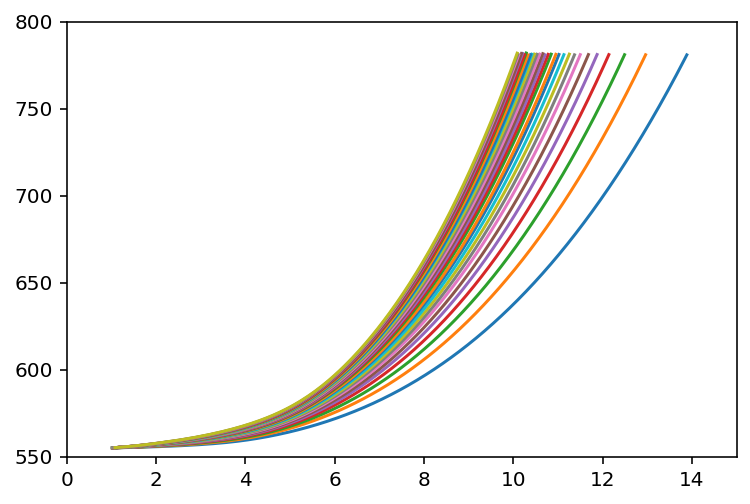

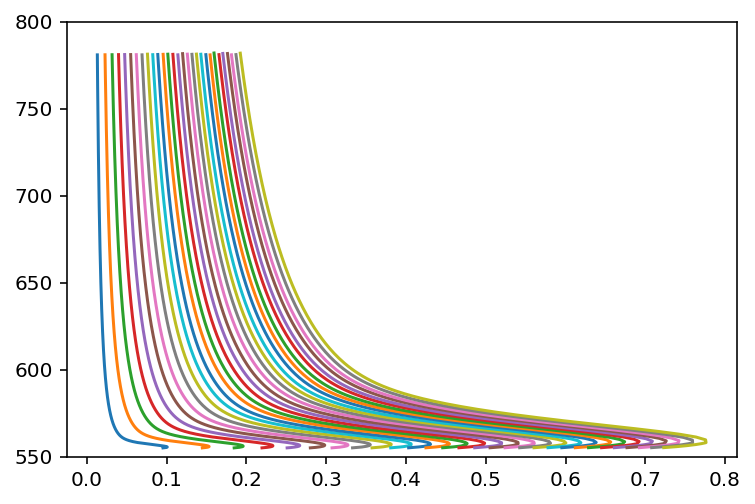

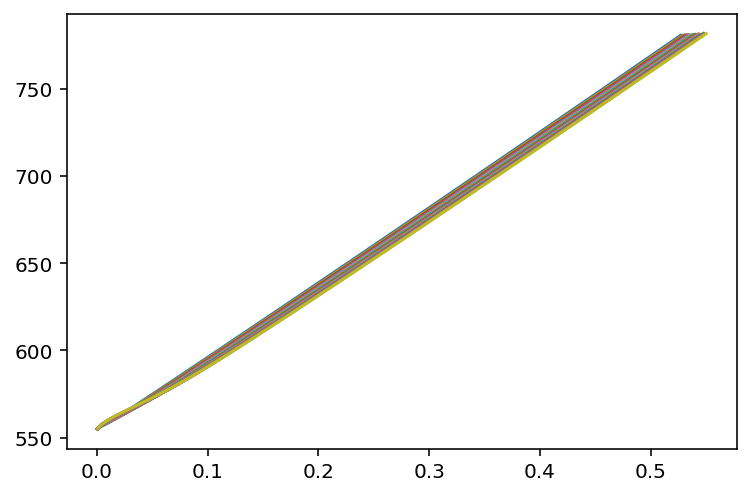

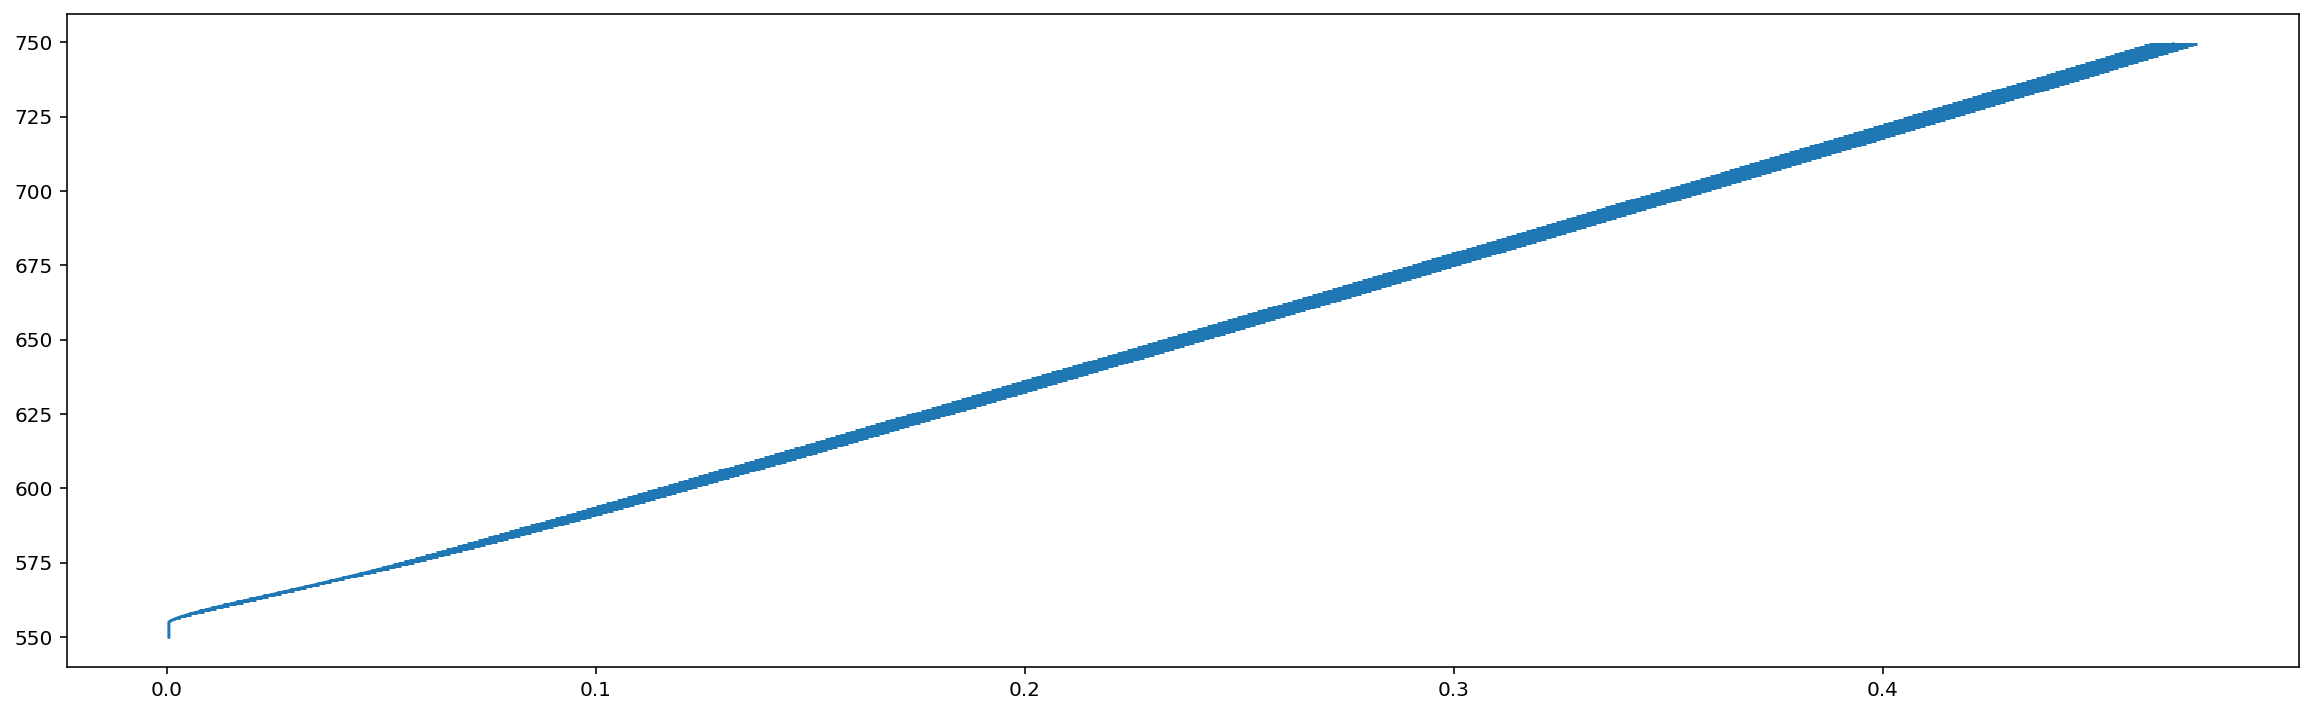

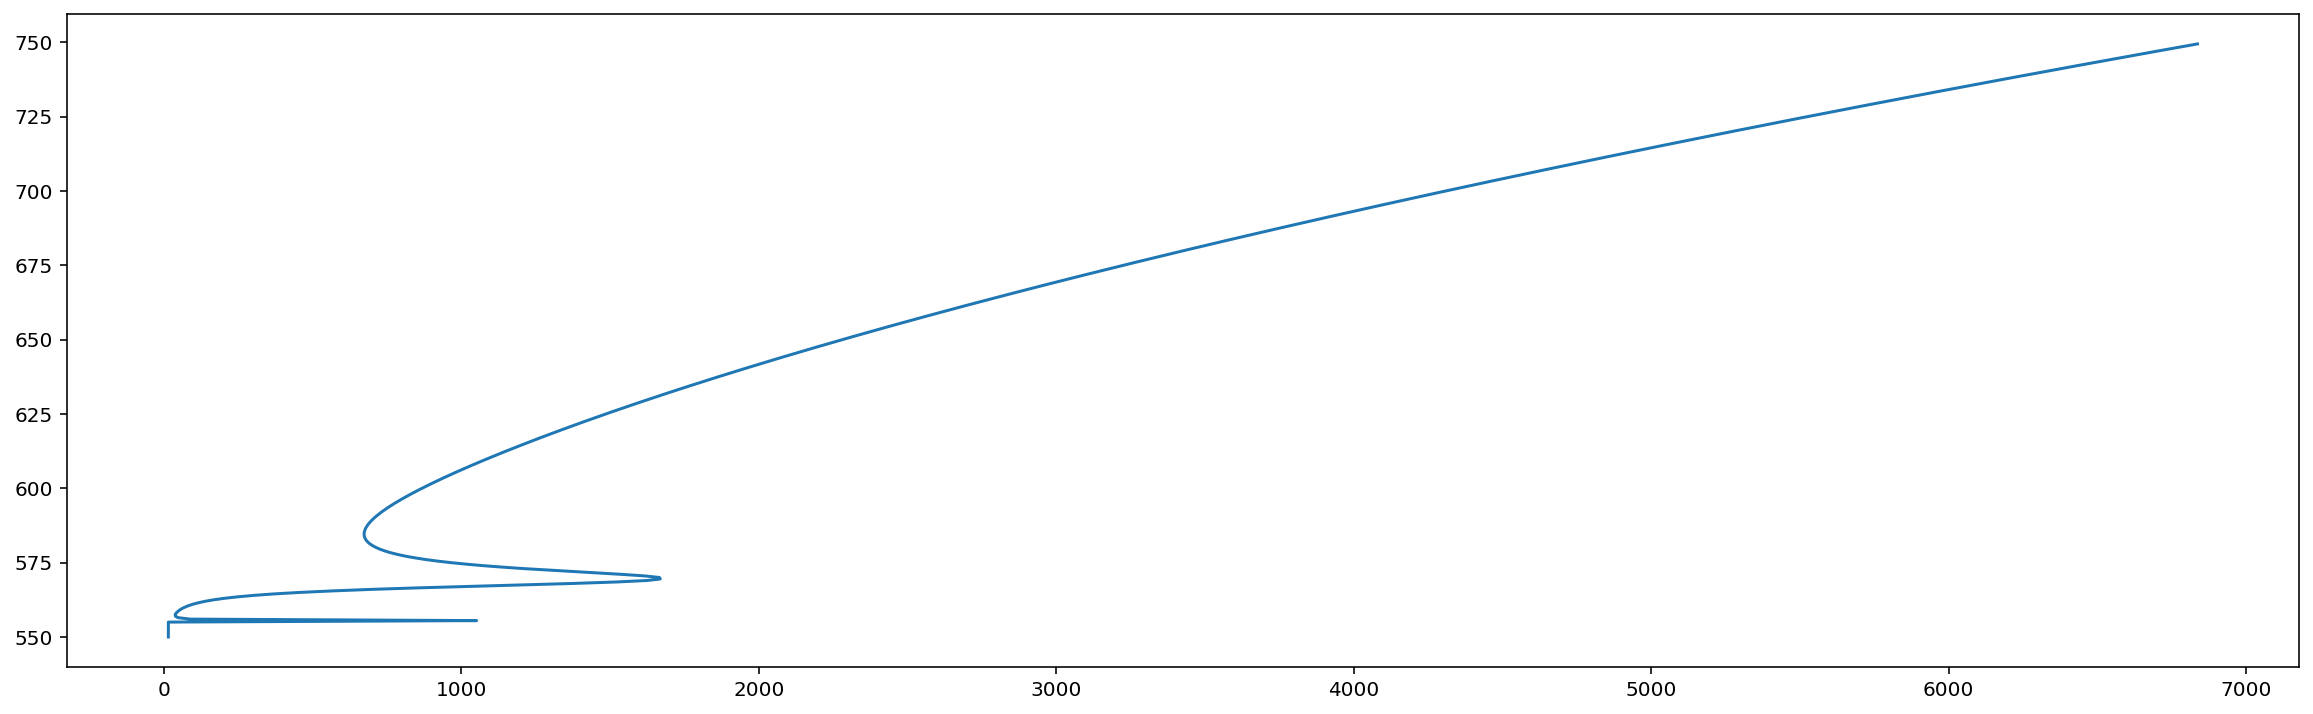

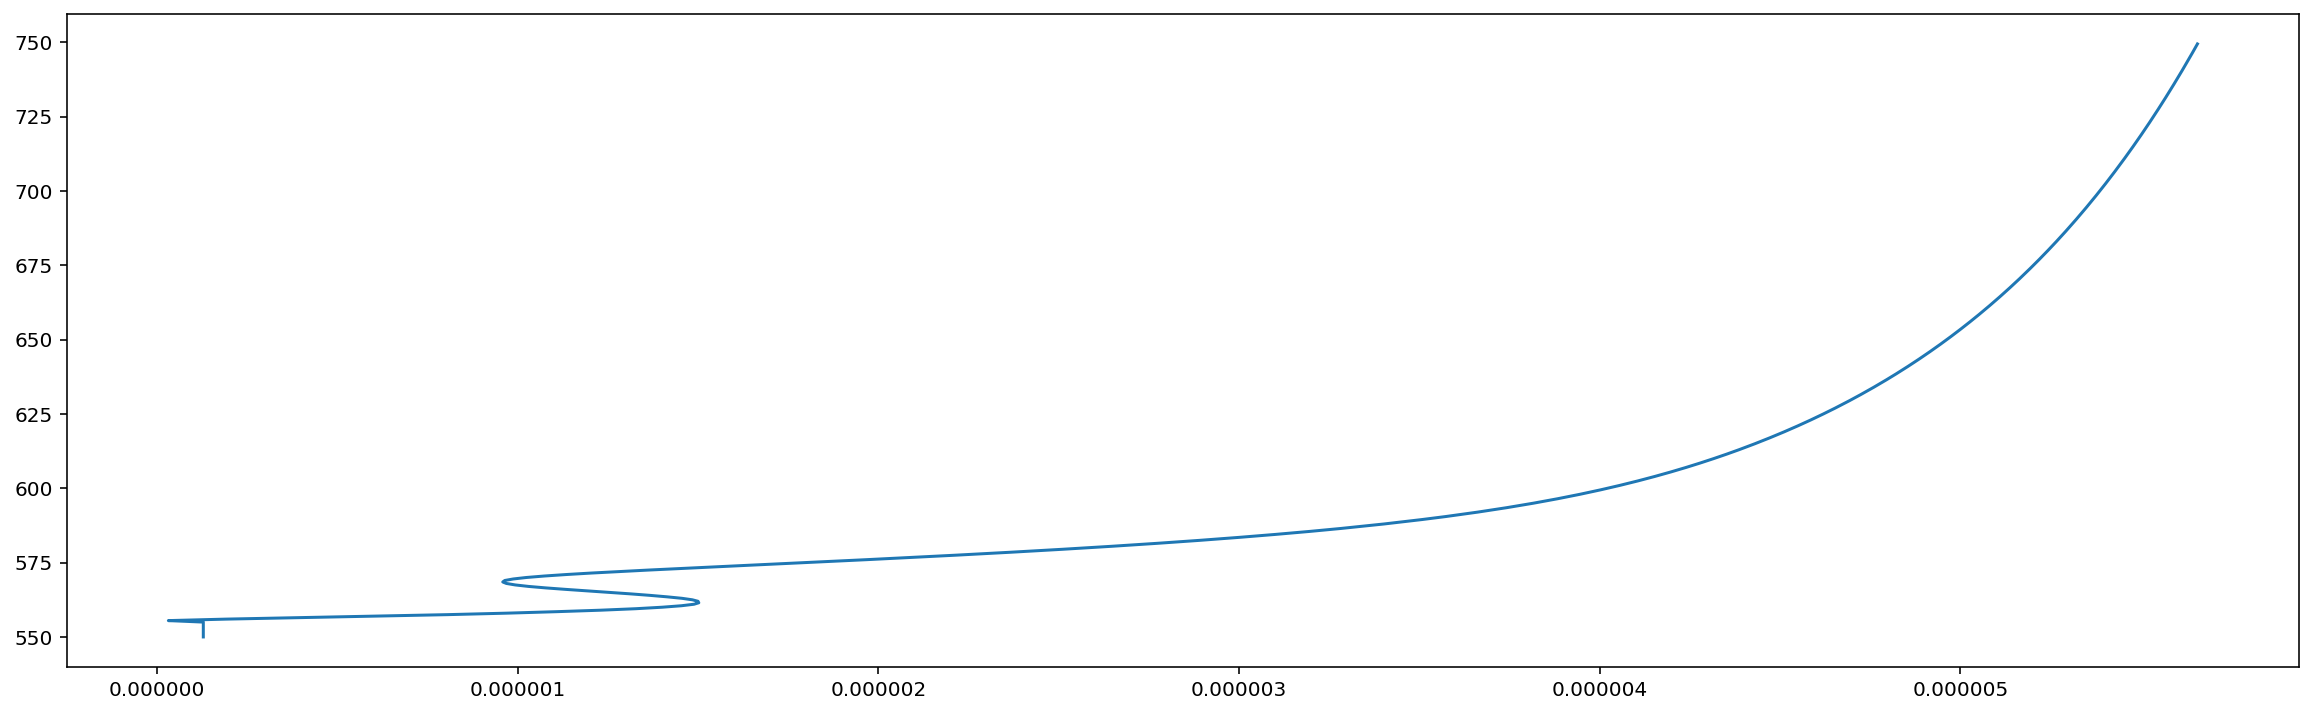

In [32]:
from metpy.interpolate import interpolate_1d
fig,ax=plt.subplots()
for w in Ppro.keys():
    ax.plot(np.array(Rpro[w])*1e6,Hpro[w],label='W={:5.1f} [cm/s]'.format(w.to('cm/s').magnitude))

ax.set_xlim([0,15])
ax.set_ylim([550,800])
#ax.legend()
fig.savefig('size_profile.png',dpi=300)

fig,ax=plt.subplots()
for w in Ppro.keys():
    ax.plot(100*(np.array(Spro[w])-1.0),Hpro[w],label='W={:5.1f} [cm/s]'.format(w.to('cm/s').magnitude))

#ax.set_xlim([0,1.2])
ax.set_ylim([550,800])
#ax.legend()
fig.savefig('SS_profile.png',dpi=300)


fig,ax=plt.subplots()
#axt = ax.twiny()
Hcommon = np.arange(550,750,0.5)
Qcommon = {}
for w in Ppro.keys():
    Qcommon[w] = np.interp(Hcommon,Hpro[w],Qpro[w])
    ax.plot(np.array(Qpro[w])*1000.0,Hpro[w],label='W={:5.1f} [cm/s]'.format(w.to('cm/s').magnitude))

Qmean = np.zeros_like(Hcommon)
Qstd  = np.zeros_like(Hcommon)

for h in range(len(Hcommon)):
    Qlevel =np.array([Qcommon[w][h] for w in Ppro.keys()])
    Qmean[h] = np.mean(Qlevel)
    Qstd[h]  = np.std(Qlevel)
    

fig,ax=plt.subplots(figsize=[20,6])
ax.errorbar(np.array(Qmean)*1000.0,Hcommon,xerr=Qstd*1000)

fig,ax=plt.subplots(figsize=[20,6])
ax.plot((Qmean)**2/Qstd**2,Hcommon)

fig,ax=plt.subplots(figsize=[20,6])
ax.plot(Qstd,Hcommon)


# axt.plot((Q2common-Q1common)*1000,Hcommon,c='k',ls='dashed')
# axt.set_xlim([-0.05,0.05])
# #ax.plot(np.array(Q2)*1000,P2)
# ax.set_xlim([0,0.5])
# ax.set_ylim([550,800])
# #ax.legend()
# fig.savefig('LWC_profile.png',dpi=300)

# fig,ax=plt.subplots()
# ax.plot(np.array(H1),P1,c='g',label='W={:5.1f} [cm/s]'.format(W1.to('cm/s').magnitude))
# ax.plot(np.array(H2),P2,c='r',marker='o',markevery=10,label='W={:5.1f} [cm/s]'.format(W2.to('cm/s').magnitude))
# #ax.plot(np.array(Q2)*1000,P2)
# # ax.set_xlim([500,1500])
# # ax.set_ylim([950,920])
# ax.legend()
# fig.savefig('P_profile.png',dpi=300)

In [ ]:
print(P1.units)
print(interpolate_1d(Pcommon,P1,Q1))


fig,ax=plt.subplots()
ax.plot(np.array(R1)*1e6,P1,c='r')
#ax.plot(np.array(Q2)*1000,P2)
#ax.set_xlim([0,1.24])
ax.set_ylim([900,850])


fig,ax=plt.subplots()
ax.plot(np.array(S1)*100-100,P1,c='r')
#ax.plot(np.array(Q2)*1000,P2)
ax.set_xlim([0,0.8])
ax.set_ylim([900,850])

In [ ]:
print(P1[-1],Q2[-1])


In [ ]:
def read_ACE_ENA_ARMBE(plot_sounding=False):
    import datetime
    datapath='/home/zzbatmos/zzbatmos_common/common/Data/ARM/ARMBE/'
    fn = 'enaarmbeatmC1.c1.20170101.003000.nc'
    from metpy.plots import Hodograph, SkewT
    import matplotlib.gridspec as gridspec
    from metpy.interpolate import interpolate_1d

    ARMBEATM=ARMBE.ARM_BE_ATM()
    ARMBEATM.read_from_file(datapath+fn)
    ACEENA_time = datetime.datetime(2017,7,18,12,0,0)
    dt = np.array([(ARMBEATM.datetime[i] - ACEENA_time) for i in range(len(ARMBEATM.datetime)) ])
    ACEENA_time_idx = np.argmin(np.abs(dt))
    
    if plot_sounding:
        print(ARMBEATM.temperature_p.shape)
        fig = plt.figure(figsize=(9, 9))


        # Grid for plots
        gs = gridspec.GridSpec(3, 3)
        skew = SkewT(fig, rotation=45, subplot=gs[:, :2])

        # Plot the data using normal plotting functions, in this case using
        # log scaling in Y, as dictated by the typical meteorological plot
        print(ARMBEATM.temperature_p[0].units)
        skew.plot(ARMBEATM.pressure,ARMBEATM.temperature_p[ACEENA_time_idx,:].to('degreeC') , 'r')
        skew.plot(ARMBEATM.pressure,ARMBEATM.dewpoint_p[ACEENA_time_idx,:].to('degreeC'), 'g')
        skew.plot_barbs(ARMBEATM.pressure,
                        ARMBEATM.u_wind_p[ACEENA_time_idx,:],
                        ARMBEATM.u_wind_p[ACEENA_time_idx,:])
        skew.ax.set_ylim(1000, 100)

        # Add the relevant special lines
        skew.plot_dry_adiabats()
        skew.plot_moist_adiabats()
        skew.plot_mixing_lines()

        # Good bounds for aspect ratio
        skew.ax.set_xlim(-30, 40)

        # Create a hodograph
        ax = fig.add_subplot(gs[0, -1])
        h = Hodograph(ax, component_range=60.)
        h.add_grid(increment=20)
        h.plot(ARMBEATM.u_wind_p[ACEENA_time_idx,:],ARMBEATM.u_wind_p[ACEENA_time_idx,:])

        # Show the plot
        plt.show()
    
    LCL_P,LCL_T = mpcalc.lcl(ARMBEATM.pressure[0],
                   ARMBEATM.temperature_p[ACEENA_time_idx,0],
                   ARMBEATM.dewpoint_p[ACEENA_time_idx,0])
    
    #P_h = interpolate_1d(ARMBEATM.height,)
    
    return ARMBEATM.height, ARMBEATM.pressure,\
           ARMBEATM.pressure_sfc[ACEENA_time_idx],\
           ARMBEATM.temperature_sfc[ACEENA_time_idx],\
           ARMBEATM.relative_humidity_sfc[ACEENA_time_idx],\
           ARMBEATM.temperature_p[ACEENA_time_idx,:],\
           ARMBEATM.dewpoint_p[ACEENA_time_idx,:],\
           ARMBEATM.temperature_h[ACEENA_time_idx,:],\
           ARMBEATM.dewpoint_h[ACEENA_time_idx,:]

def hydrostatic_profile(Ps,Ts,RHs,H,T_H,TD_H):
    mrs = mpcalc.mixing_ratio_from_relative_humidity(RHs, Ts, Ps)
    RH_H  = mpcalc.relative_humidity_from_dewpoint(T_H,TD_H)
    mr_H  = mpcalc.mixing_ratio_from_relative_humidity(RH_H, T_H, )
    print('surface mr',mrs.to('g/kg'))
    print('relative humidity',RH)
    Rhos = mpcalc.density(Ps,Ts)
    dz = H[1:]-H[0:-1]
    
                                

H,P,Ps,Ts,RHs,T_P,TD_P,T_H,TD_H=read_ACE_ENA_ARMBE()
P_H=mpcalc.height_to_pressure_std(H)

fig,ax=plt.subplots()
ax.plot(H,P_H)
ax.set_ylim([950,900])
ax.set_xlim([0,1000])

fig,ax=plt.subplots()
ax.plot(T_H,P_H,c='r')
ax.plot(T_P,P,c='g')
ax.set_ylim([1000,800])
ax.set_xlim([285,295])

fig,ax=plt.subplots()
ax.plot(TD_H,P_H,c='r')
ax.plot(TD_P,P,c='g')
ax.set_ylim([1000,800])

print(H[np.argmin(np.abs(P_H-950*units('hPa')))])



In [ ]:
RF_stamp = '20170718083145' # ['20170720083203','20180119121131','20180211112034'] #  ['20180211112034']#['20170720083203','20180119121131','20180211112034'] # 

IOP_stamp='IOP1'
hleg_dw_i_threshold=2.0*units('m/s')
save_path='./'
RF_AIMMS, RF_FCDP, RF_TDS, RF_ARSCL, RF_CEIL, RF_VISST,RF_TDL,RF_LWCair,RF_mPSD,RF_holodec,RF_AAFCCN,RF_AOSCCN = \
                        ACEENA_Read_RF_data.Read_RF_data(IOP_stamp, RF_stamp,hleg_dw_i_threshold)
RF_hlegs = ACEENA_hleg_microphysics.hleg(RF_AIMMS, RF_FCDP, RF_TDS,RF_LWCair, RF_mPSD, RF_holodec ,\
                                             figure_path=save_path,verbose=False)
RF_vlegs = ACEENA_vleg_microphysics.vleg(RF_AIMMS, RF_FCDP, RF_LWCair,RF_TDL,figure_path=save_path,verbose=False)

In [ ]:
fig,ax=plt.subplots()
hleg=[5,8]
wbins=np.arange(-150,180,5)
for h in hleg:
    W=RF_AIMMS.w_w[RF_AIMMS.hleg_s_idx[h]:RF_AIMMS.hleg_e_idx[h]]*100.0
    ax.hist(W,bins=wbins,lw=3,density=True,label='hleg{:02d}'.format(h),histtype='step')
ax.legend()
ax.set_xlabel('W [cm/s]',fontsize='x-large')
ax.set_ylabel('PDF',fontsize='x-large')


In [ ]:
Ppro = {}
W=np.arange(10,150,5)
for w in W:
    Ppro[w] = np.random.random(10)

In [ ]:
Ppro